In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(777)

In [28]:
def generate_lambda(T):
    lambdas = np.zeros(T + 1)
    lambdas[0] = 0.0
    for k in range(1, T + 1):
        lambdas[k] = (1 + np.sqrt(1 + 4 * lambdas[k - 1]**2)) / 2
    return lambdas


def nagd(func, T, mu_0, alpha, N, L0=0):
    lambdas = generate_lambda(T)
    x_hist = [np.zeros]
    y_k = np.zeros(N)
    x_k = np.zeros(N)
    obj_val_hist = [func['func'](x_k)]

    for k in range(1, T + 1):
        mu_k = mu_0 / (k**alpha)
        L_k = L0 + func['sigma'] / mu_k

        grad_f = func['grad_func'](y_k, mu_k)
        x_knext = y_k - (1 / L_k) * grad_f
        gamma_k = lambdas[k - 1] / lambdas[k]

        y_knext = x_knext + gamma_k * (x_knext - x_k)
        
        x_k = x_knext
        y_k = y_knext

        x_hist.append(x_k)
        obj_val_hist.append(func['func'](x_k))

    return obj_val_hist

In [29]:
def lasso_obj(x, A, b, reg_lambda):
    return 0.5 * np.linalg.norm(A @ x - b)**2 + reg_lambda * np.linalg.norm(x, 1)


def lasso_smooth_grad(x, A, b, reg_lambda, mu_k):
    grad_L2 = A.T @ (A @ x - b)
    u_mu = np.sign(x) * np.minimum(np.abs(x / mu_k), reg_lambda)
    return grad_L2 + u_mu


def setup_lasso(A, b, reg_lambda):
    N = A.shape[1]
    L0 = np.linalg.norm(A.T @ A, 2)

    return {
        'func': lambda x: lasso_obj(x, A, b, reg_lambda), 
        'grad_func': lambda x, mu: lasso_smooth_grad(x, A ,b, reg_lambda, mu),
        'sigma': 1.0,
        'L0': L0,
        'N': N
    }


def solve_lasso(A, b, reg_lambda):
    m, n = A.shape 
    x = cp.Variable(n)

    func = cp.Minimize(0.5 * cp.sum_squares(A @ x - b) + reg_lambda * cp.norm(x, 1))
    
    problem = cp.Problem(func)
    problem.solve()

    return problem.value

Running for alpha = 0
Running for alpha = 0.5
Running for alpha = 0.75
Running for alpha = 1.0
Running for alpha = 1.25
Running for alpha = 1.5
Running for alpha = 1.75


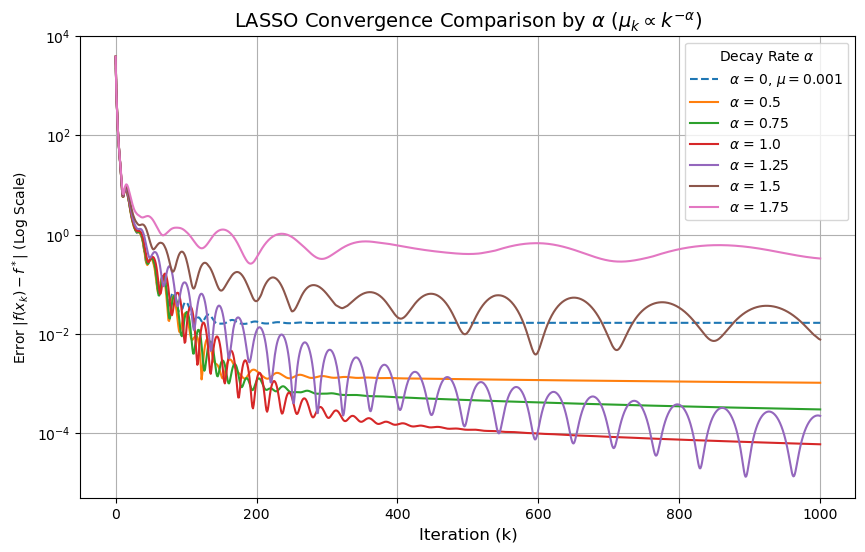

In [30]:
m, n = 100, 50
A_lasso = np.random.randn(m, n)
x_true = np.random.randn(n)
b_lasso = A_lasso @ x_true + 0.1 * np.random.randn(m)
lambda_lasso = 0.5

lasso_problem = setup_lasso(A_lasso, b_lasso, lambda_lasso)

T_max = 1000
mu = 0.001    # mu for alpha = 0
mu_0 = 1.0     # mu for alpha != 0
alphas = [0, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
results = {}

f_star_lasso = solve_lasso(A_lasso, b_lasso, lambda_lasso)

for alpha in alphas:
    print(f"Running for alpha = {alpha}")
    obj_hist = nagd(
        func=lasso_problem, 
        T=T_max, 
        mu_0=mu_0, 
        alpha=alpha, 
        N=lasso_problem['N'], 
        L0=lasso_problem['L0']
    )
    results[alpha] = obj_hist

plt.figure(figsize=(10, 6))

for alpha, history in results.items():
    error = np.array(history) - f_star_lasso 

    if alpha == 0:
        plt.plot(np.arange(T_max + 1), error, label=r'$\alpha$ = 0, $\mu = {}$'.format(mu), linestyle='--')

    else:
        plt.plot(np.arange(T_max + 1), error, label=r'$\alpha$ = {}'.format(alpha))

plt.xlabel('Iteration (k)', fontsize=12)
plt.ylabel('Error $|f(x_k) - f^*|$ (Log Scale)')
plt.title(r'LASSO Convergence Comparison by $\alpha$ ($\mu_k \propto k^{-\alpha}$)', fontsize=14)
plt.grid(1)
plt.yscale('log')
plt.legend(title=r'Decay Rate $\alpha$')
plt.show()